In [ ]:
ARBISCAN_API = ""

In [3]:
EPOCH = 2

In [4]:
address_map = {
    'mine': '0xb0438eFFB3E55Da89929f8FE999Ec2e107B6c16c',
    'comfy': '0x0100e22f222753f6021abEB3F7E4AF4c57467cc9',
    'phi': '0xd692e8e0DBd3b4b9dFefE0500F097c17AbEA4583',
    'large': '0x3924aC2F5782Ef1b0fd664495AB99052e6C4B86e',
    'small': '0xd38cA3d05f4Dcc012A6F537B320CFB2c07FE8D02',
    'screamInVoid': '0xdeaf42d4a2cc1dc14505ce4e4f59629aec253d75',
    'electro1820': '0x57aeb1c3bc806c0a53998ab5215a7a1022faf551',
    '0x6851': '0x90f15e09b8fb5bc080b968170c638920db3a3446',
    'prolasky': '0xaB32bf707C9D9F78f1101F9b7B4D6B4b3727b6ea',
    "gusher": "0x9f25248e8465a4a5106948615c6Db2ed1E1b9052",
    "2nd": "0x84eAE603c90Eb7965f8e3659B8E1c23f0C8Fd989"
    
}

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from scipy import stats
import statsmodels.api as sm


from scan import ARBISCAN_BEBOP

### Data

In [6]:
arbiscan = ARBISCAN_BEBOP()
df = arbiscan.all_trades(address_map, EPOCH, time_cutoff=20*60)

In [7]:
df = df[df["data"] < .03]

### Formatting

In [8]:
## Tried a weird strategy on this date
df = df[df["timeStamp_dt"].dt.date != dt.datetime(2024, 6, 17).date()]

##Zegos dont make sense
df = df[df["data"] > 0]

## Filter trades that don't make sense, these has multiple tx's
skip = [
"0x5a43700871ed8c115b6d56102e8cf815ea2f1605f7951c92c11336acd47be0a0",
"0x0cde7544abd818c9cf4e9d25ae80be4472f5de3413a8a4ef3aa8b21336ab83fa"
]
df = df[~df['hash'].isin(skip)]

df.to_csv("all_trades.csv")

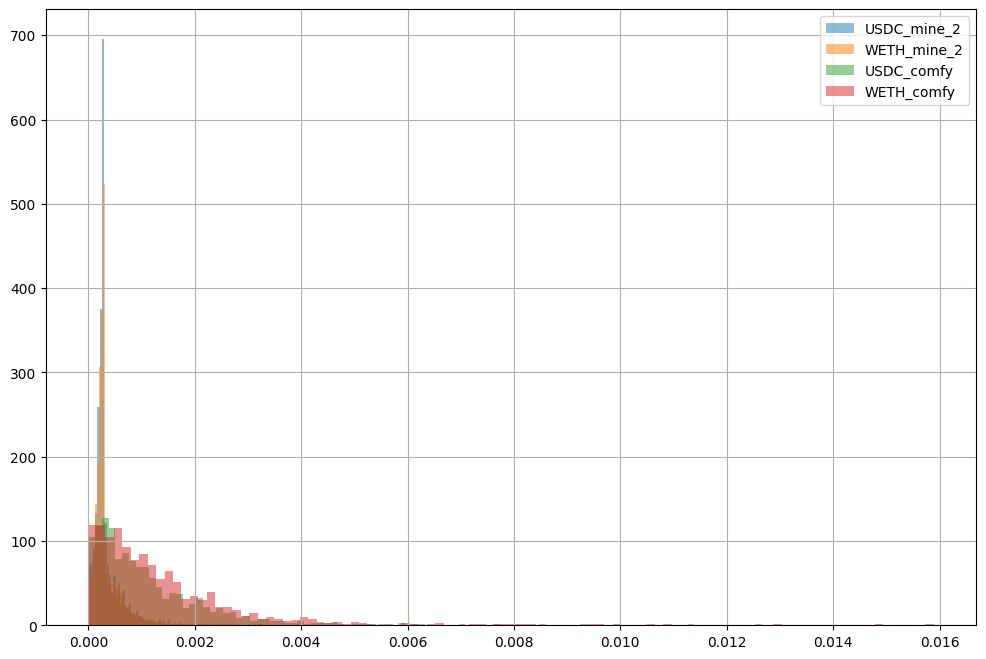

In [9]:
plt.figure(figsize=(12, 8))

for label in set(df["label"]):
    # print(f"Label: {label}, USDC_data > 0: {df[(df['USDC_data'] > 0) & (df['label'] == label)]['USDC_data'].count()}, WETH_data > 0: {df[(df['WETH_data'] > 0) & (df['label'] == label)]['WETH_data'].count()}")
    if label in ["mine_1", "mine_2", "comfy"]: ##The others use different methods, must explore
        df[(df["USDC_data"] > 0) & (df["label"] == label)]["USDC_data"].hist(bins=100, alpha=0.5, label = "USDC_" + label)
        df[(df["WETH_data"] > 0) & (df["label"] == label)]["WETH_data"].hist(bins=100, alpha=0.5, label = "WETH_" + label)
    
plt.legend()

# Display the plot
plt.show()

In [10]:
df[(df["USDC_data"] > 0) & (df["label"] == label)]["USDC_data"]
df[(df['USDC_data'] > 0) & (df['label'] == label)]['USDC_data'].count()

np.int64(1314)

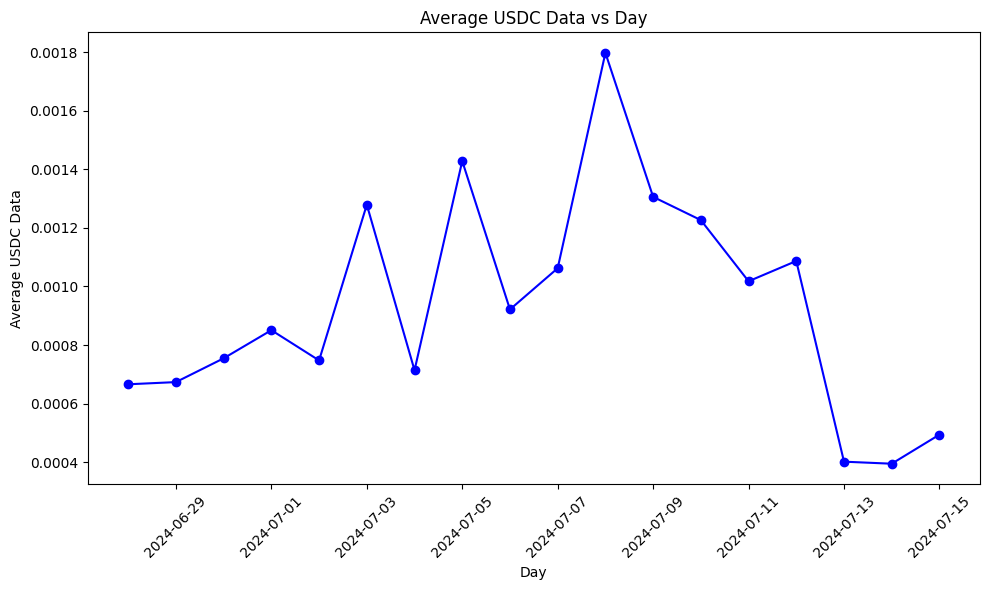

In [11]:
# Plotting

daily_avg = df.groupby(pd.Grouper(key='timeStamp_dt', freq='D'))['data'].mean()
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(daily_avg.index, daily_avg.values, marker='o', linestyle='-', color='blue')  # Customize as needed

# Customizing the plot
plt.xlabel('Day')
plt.ylabel('Average USDC Data')
plt.title('Average USDC Data vs Day')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

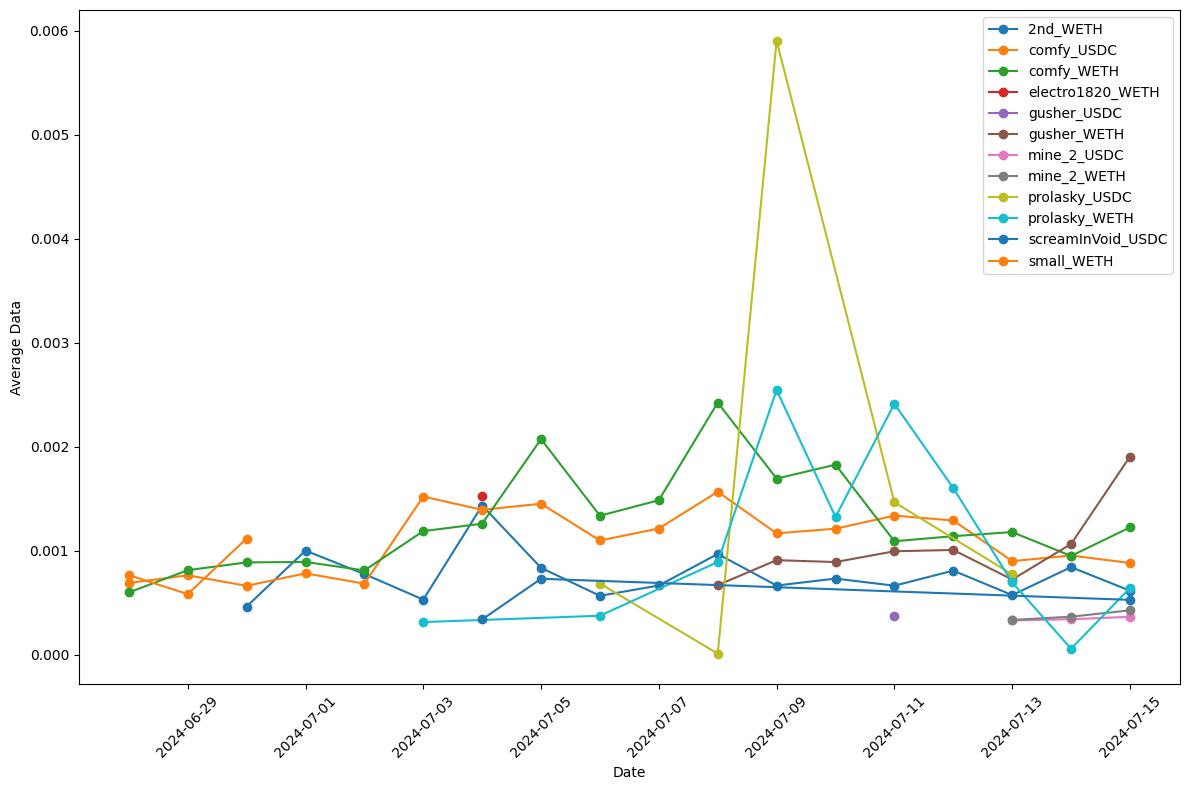

In [12]:
import matplotlib.pyplot as plt

def plot_data_by_label_and_symbol(df, daily: bool=True):
    plt.figure(figsize=(12, 10))
    grouped = df.groupby(['label', 'tokenSymbol'])
    for (label, symbol), group in grouped:
        # Calculate daily average if needed, here assuming 'timeStamp_dt' and 'data' are columns in the DataFrame
        if daily: daily_avg = group.groupby(group['timeStamp_dt'].dt.date)['data'].mean()
        else: daily_avg = group.groupby(group['timeStamp_dt'].dt.hour)['data'].mean()
        daily_avg.plot(label=f'{label}_{symbol}', marker='o', linestyle='-', figsize=(12, 8))
            
    plt.legend()
    plt.xlabel('Date' if daily else 'Hour')
    plt.ylabel('Average Data')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Assuming 'df' is your DataFrame containing all trades with 'label' and 'tokenSymbol' columns
plot_data_by_label_and_symbol(df)

/tmp/ipykernel_69605/1560507943.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


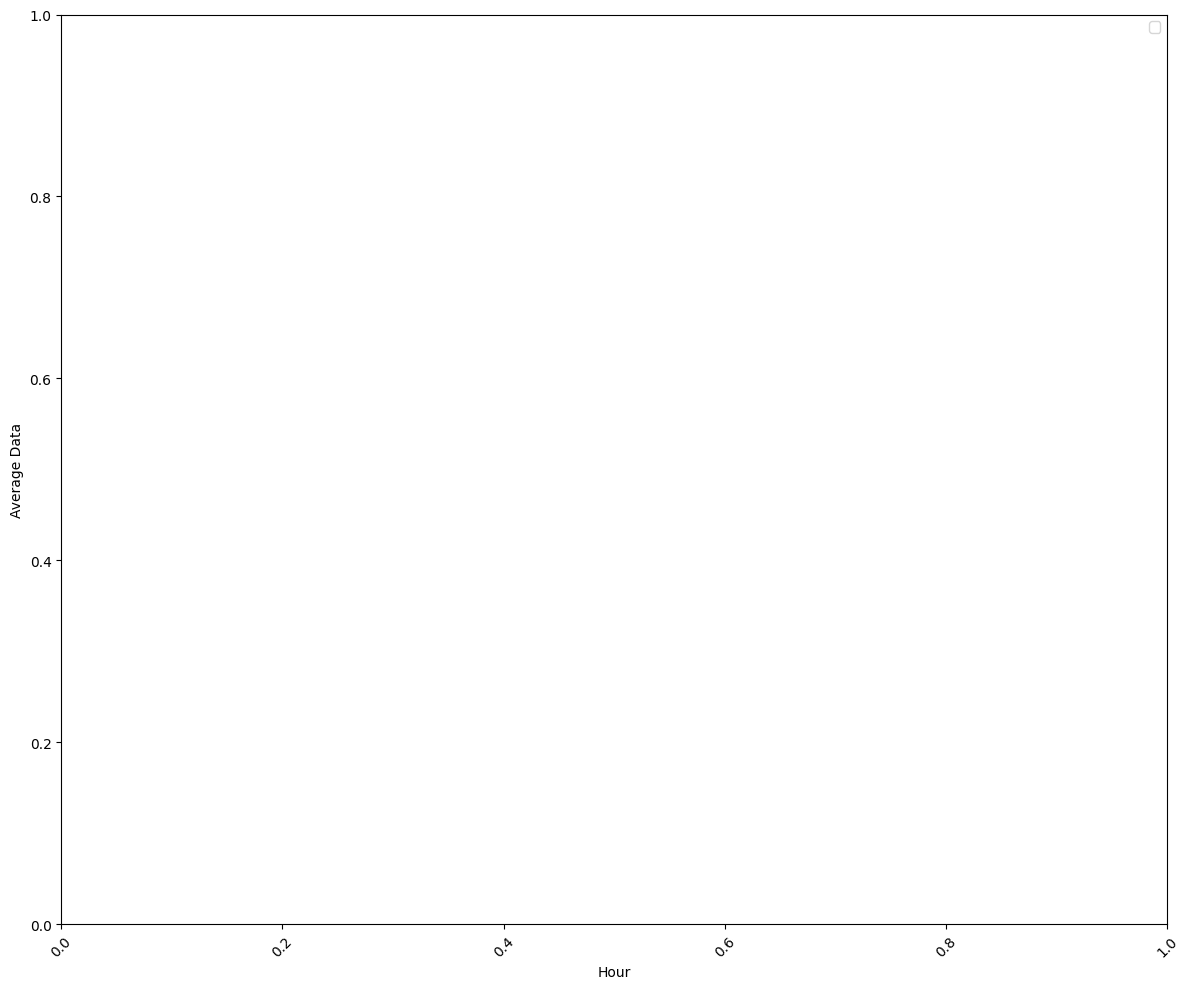

In [13]:
last_days = df[(df["timeStamp_dt"].dt.date > dt.datetime(2024, 6, 26).date()) & (df["timeStamp_dt"].dt.date < dt.datetime(2024, 6, 28).date())]
plot_data_by_label_and_symbol(last_days, False)

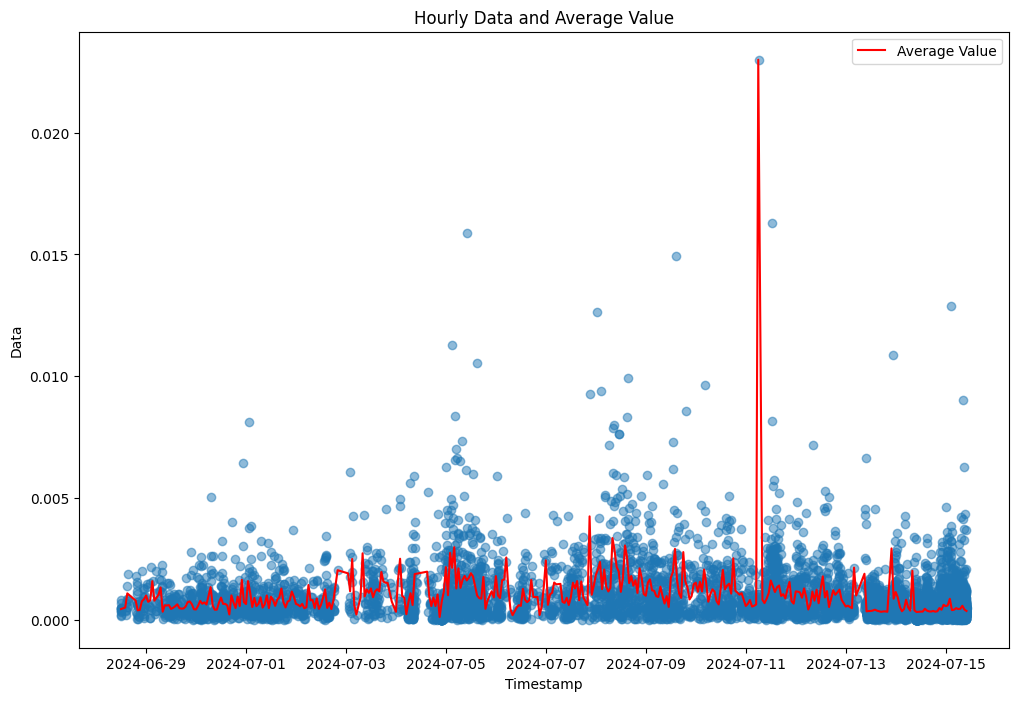

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure timeStamp_dt is in datetime format and round down to the nearest hour
df['timeStamp_hour'] = pd.to_datetime(df['timeStamp_dt']).dt.floor('h')

plt.figure(figsize=(12, 8))
plt.scatter(df["timeStamp_dt"], df["data"], alpha=0.5)  # Added alpha for better visualization

# Group by the rounded timeStamp_dt to calculate hourly averages
average_values = df.groupby(df["timeStamp_hour"]).mean(numeric_only=True)

# Plot average values
plt.plot(average_values.index, average_values['data'], color='red', label='Average Value')

plt.xlabel('Timestamp')
plt.ylabel('Data')
plt.title('Hourly Data and Average Value')
plt.legend()

plt.show()

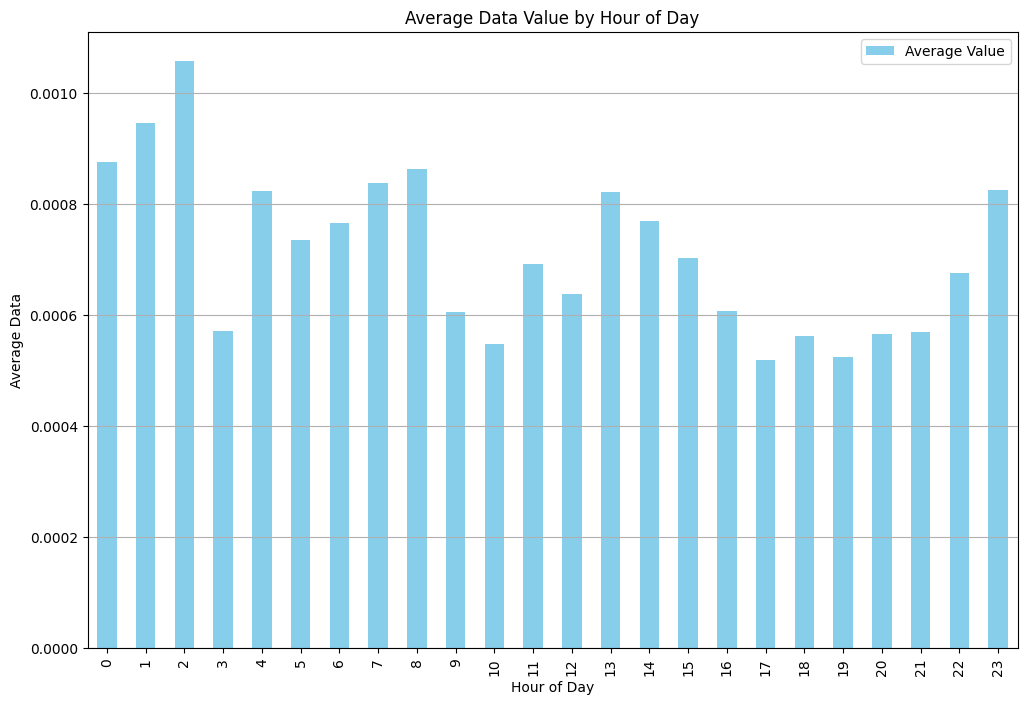

In [15]:
df['hour_of_day'] = df['timeStamp_dt'].dt.hour

plt.figure(figsize=(12, 8))
# Plotting all data points can be misleading due to overplotting, consider plotting averages or distributions

# Group by the hour of day to calculate averages
average_values_by_hour = df.groupby('hour_of_day')['data'].mean()

# Plot average values by hour of day
average_values_by_hour.plot(kind='bar', color='skyblue', label='Average Value')

plt.xlabel('Hour of Day')
plt.ylabel('Average Data')
plt.title('Average Data Value by Hour of Day')
plt.legend()

plt.xticks(range(0, 24))  # Ensure x-ticks for every hour
plt.grid(axis='y')

plt.show()

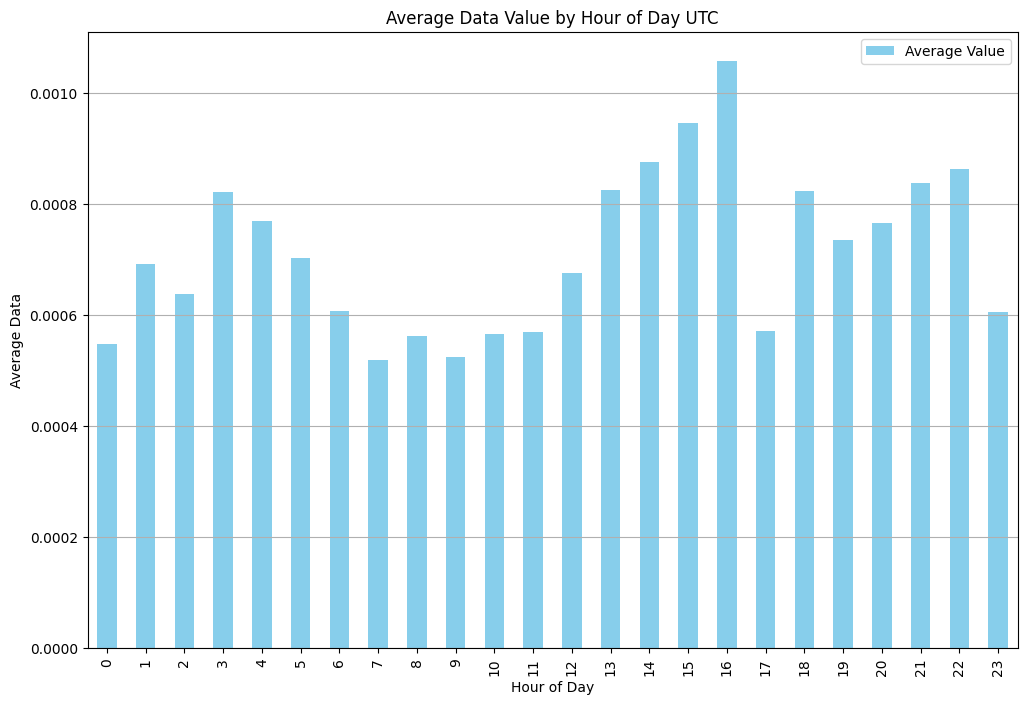

In [16]:
try: df['timeStamp_dt'] = pd.to_datetime(df['timeStamp_dt']).dt.tz_localize('Australia/Melbourne')
except TypeError: pass

# Step 2: Convert to UTC
df['timeStamp_utc'] = df['timeStamp_dt'].dt.tz_convert('UTC')

# Step 3: Extract hour of day in UTC
df['hour_of_day_utc'] = df['timeStamp_utc'].dt.hour

plt.figure(figsize=(12, 8))
# Plotting all data points can be misleading due to overplotting, consider plotting averages or distributions

# Group by the hour of day to calculate averages
average_values_by_hour = df.groupby('hour_of_day_utc')['data'].mean()

# Plot average values by hour of day
average_values_by_hour.plot(kind='bar', color='skyblue', label='Average Value')

plt.xlabel('Hour of Day')
plt.ylabel('Average Data')
plt.title('Average Data Value by Hour of Day UTC')
plt.legend()

plt.xticks(range(0, 24))  # Ensure x-ticks for every hour
plt.grid(axis='y')

plt.show()

In [17]:
display(df.groupby(['label', 'tokenSymbol'])['data'].agg(["mean", "std"]))

mean       std
label        tokenSymbol                    
2nd          WETH         0.000695  0.000557
comfy        USDC         0.001132  0.001167
             WETH         0.001376  0.001518
electro1820  WETH         0.001523       NaN
gusher       USDC         0.000373       NaN
             WETH         0.000975  0.001157
mine_2       USDC         0.000342  0.000301
             WETH         0.000370  0.000370
prolasky     USDC         0.001310  0.001770
             WETH         0.001055  0.002726
screamInVoid USDC         0.000485  0.000589
small        WETH         0.000688  0.000619

In [18]:
display(df.groupby(['label', 'tokenSymbol'])['timeDelta'].agg(["mean", "std"]))

mean         std
label        tokenSymbol                        
2nd          WETH          77.801872  175.214662
comfy        USDC         212.213090  203.441787
             WETH         272.887588  215.227837
electro1820  WETH         110.000000         NaN
gusher       USDC          34.000000         NaN
             WETH         107.532446  153.494743
mine_2       USDC          19.911350   20.093390
             WETH          20.970168   38.560385
prolasky     USDC         260.428571  306.300926
             WETH         145.555556  246.973986
screamInVoid USDC          34.821429   46.633128
small        WETH         278.422018  141.012299

In [19]:
# Function to plot data, regression line, and print statistics
def plot_with_regression(df, symbol):
    plt.figure(figsize=(12, 8))
    # Scatter plot
    plt.scatter(df['price'], df['data'], label=f'{symbol} Data')
    
    # Regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['price'], df['data'])
    
    # Regression line
    line = slope * df['price'] + intercept
    plt.plot(df['price'], line, label=f'{symbol} Regression Line', color='red')
    
    # Plot adjustments
    plt.xlabel('Price')
    plt.ylabel('Data')
    plt.title(f'{symbol} Price vs Data with Regression Line')
    plt.legend()
    plt.show()
    
    # Print statistics
    print(f'{symbol} Regression Statistics:')
    print(f'Slope: {slope}')
    print(f'Intercept: {intercept}')
    print(f'R-value: {r_value}')
    print(f'P-value: {p_value}')
    print(f'Standard Error: {std_err}')


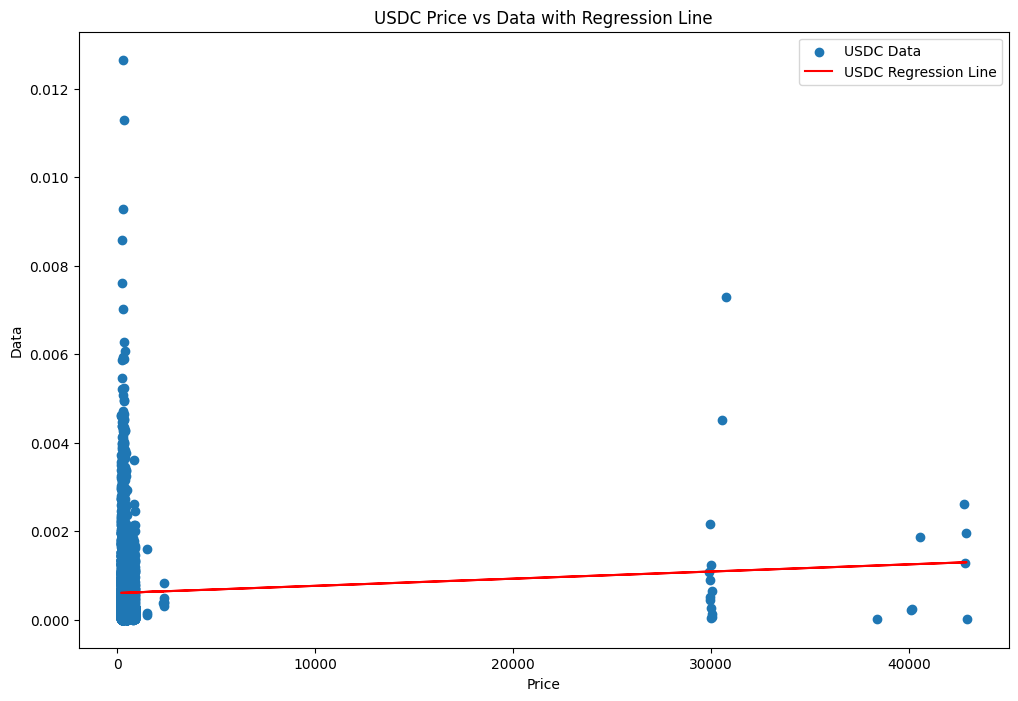

USDC Regression Statistics:
Slope: 1.6179881889697204e-08
Intercept: 0.0006041039953379104
R-value: 0.048913986114040256
P-value: 0.001762477625011338
Standard Error: 5.1698656854044745e-09


In [20]:
plot_with_regression(df[df["tokenSymbol"] == "USDC"], 'USDC')

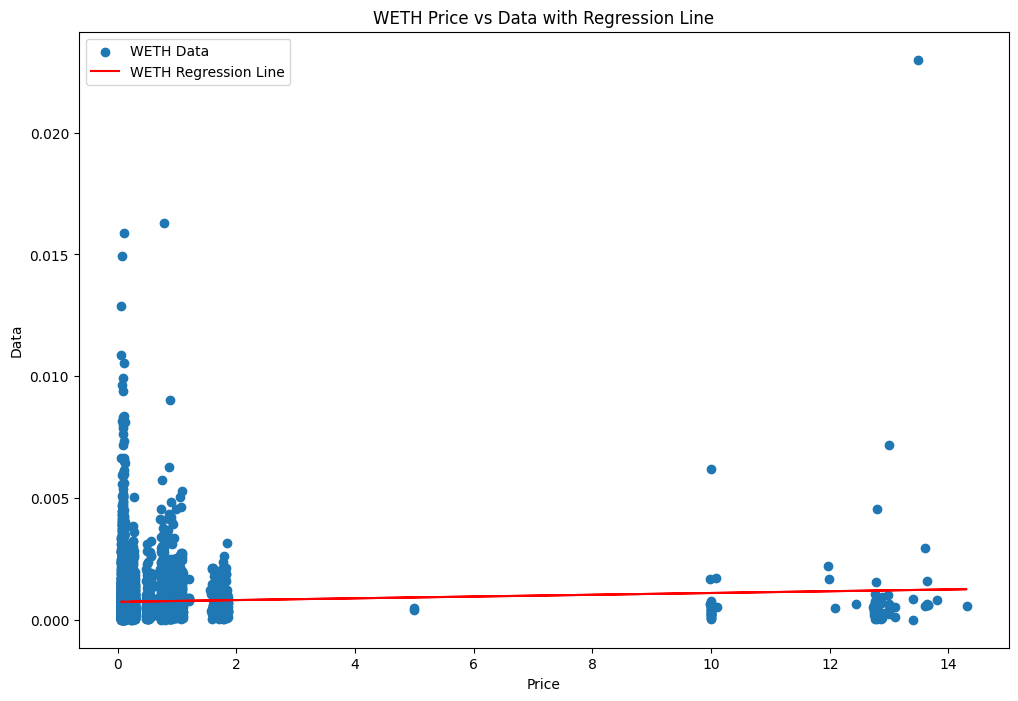

WETH Regression Statistics:
Slope: 3.631898735937193e-05
Intercept: 0.0007342907162510737
R-value: 0.04984183659276951
P-value: 0.0003727468207725708
Standard Error: 1.019894820807423e-05


In [21]:
# Plot for ETH
plot_with_regression(df[df["tokenSymbol"] == "WETH"], 'WETH')

In [22]:
X = df[df["tokenSymbol"] == "WETH"][['hour_of_day', 'price']]  # Independent variables
y = df[df["tokenSymbol"] == "WETH"]['data']  # Dependent variable
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   data   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     15.96
Date:                Mon, 15 Jul 2024   Prob (F-statistic):           1.23e-07
Time:                        20:00:44   Log-Likelihood:                 27644.
No. Observations:                5094   AIC:                        -5.528e+04
Df Residuals:                    5091   BIC:                        -5.526e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0009    3.1e-05     27.489      

In [23]:
X = df[df["tokenSymbol"] == "USDC"][['hour_of_day', 'price']]  # Independent variables
y = df[df["tokenSymbol"] == "USDC"]['data']  # Dependent variable
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   data   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     19.79
Date:                Mon, 15 Jul 2024   Prob (F-statistic):           2.79e-09
Time:                        20:00:44   Log-Likelihood:                 23270.
No. Observations:                4086   AIC:                        -4.653e+04
Df Residuals:                    4083   BIC:                        -4.651e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0007   2.74e-05     26.834      

In [24]:
71978587364126836/ 7.198703999999999e+16

0.9998825811441454

In [25]:
df[(df["label"] == "prolasky") & (df["timeStamp_utc"] >= dt.datetime(2024, 7, 6, tzinfo=dt.timezone.utc))][["price", "timeDelta", "data"]].agg(["mean", "std"])

,price,timeDelta,data
mean,7223.399045,171.970000,0.001123
std,14289.898758,264.706869,0.002576


In [26]:
2_000_000/10_000

200.0